<a href="https://colab.research.google.com/github/sbowma15/Pupil_Location_Finder/blob/main/pupil_location_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

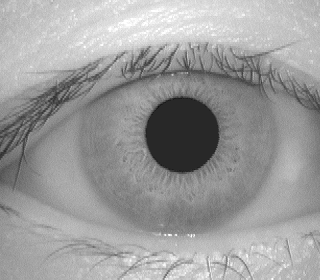

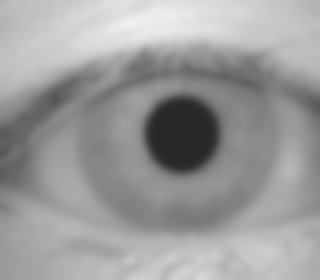

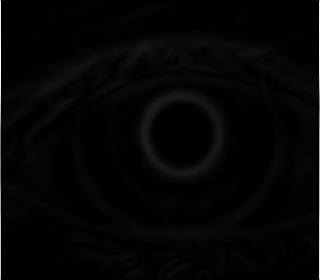

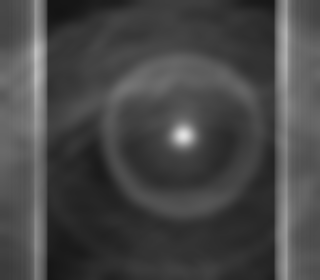

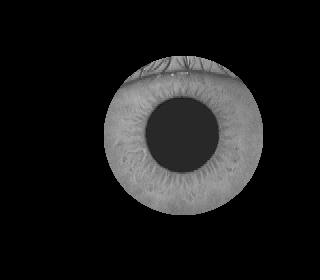

In [ ]:
#This program is designed to find the location of a pupil by using pixel values
#and certain filters/ kernals to give the proper output necessary to finding the
#circle that makes up the pupil. First the image is read in from the file-path.
#Imediately after the image is read in, the image is converted to grayscale so
#the pixel values will be more easily and readily digestible to the functions we
#will be evaluating. After gray-scaling, the image will be ran through an 91x91
#"Gaussian Blur" function we get from importing our Gaussian Blur library. When
#the image is used with gaussian blur, the out-put is a much smoother image.
#The smoother image will be useful because there are less individual areas with
#high contrast, which leaves mostly just the pupil with a high contrast area.
#After, the image pixels are ran against the Sobel filter kernal the gradient is
#calculated BEFORE the "normalization" of the pixels for more accurate gradient.
#Now a spatial filter is applied to the gradient image, "grad". Methods iterate
#through each pixle location value and compare with the rest of the pixels in a
#given block size. The methods use the comparison's for relativity in order to
#find the most intense pixels. This version of "grad" is put into "eye_rim" and
#holds the information to be used as the center of the pupil. Then the center
#of the pupil is used with a radius (whose tolerence is predetermined and hard-
#-coded) in order to essentially "cut-out" the pupil from the original image in
#and display only the pupil, showing that its location has been determined.

import numpy as np
import collections
import cv2
import math
import random
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d

#################################################
#Smoothing
#################################################

#Reads the image in from hardcoded path(Can be made to be dynamic later)
img=cv2.imread('/content/sample_data/iris.bmp')

#"img"is converted to gray-scale for program digestibility, then saved in "im"
im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#I used Gaussian blur with a 91x91 block because I know the max radius of the
#pupil is 45 pixels so a 91x91 block has a greater possibility of being able to
#to fit the entire pupil and smoothing out the image more evenly
dst = cv2.GaussianBlur(im, (91,91), cv2.BORDER_DEFAULT )

#Grayscaled image and image after gaussian blur displayed
cv2_imshow(im)
cv2_imshow(dst)

##################################################
#Using sobel for edge detection
##################################################

#The classic sobel filter kernal  used for convolution with image
sobel_vert = np.array([[-1.0, 0.0, 1.0],
                       [-2.0, 0.0, 2.0],
                       [-1.0, 0.0, 1.0]])

#creating horizontal kernal used for horizontal convolution
sobel_horiz = sobel_vert.T

#convolution with both horizontal and vertical kernals and original output img
#named "dst"
d_horiz = convolve2d(dst, sobel_horiz, mode='same', boundary = 'symm', fillvalue=0)
d_vert = convolve2d(dst, sobel_vert, mode='same',boundary='fill', fillvalue=0)

#Here we find the gradient by calculating for the square root of both verticle
#and horizontal convolution outputs which are both raised to the second power
grad = np.sqrt(np.square(d_horiz)+np.square(d_vert))

#Here we "normalize" the convolution results before displaying. Convolve2d does
#not automatically normalize before returning an output. We choose this method
#so we have a more accurate input for the calculation of the gradient edge above
#Calculating the gradient edge before "Normalization" means we must normalize
#the pixels now
grad *= 255.0/np.max(grad)

#The max gradient image is now displayed
cv2_imshow(grad)

###################################################
#The Spatial Filter
###################################################

#This method is called later for finding out whether or not a pixel is within
#range of the radius, which is also passed in later.
def in_circle(x,y, center_x, center_y, radius):

    #Pythagoreans again, used to calc. distance between points for later call
    distance = math.sqrt(math.pow(x-center_x,2)+math.pow(y-center_y,2))

#this is used as a sort of "truthy/ falsey" variable later where after the call
#to this method, the computer will know whether or not the certain pixel is in
#range then dealt with accordingly(Pseudo: if distance !< radius, then pixel=0 )
    return (distance < radius)

 #this method is called later and returns the values for the two radii. This way
 #there is a pixel "tolerence"
def in_disk(x, y, center_x, center_y, inner_radius, outer_radius):
    return not in_circle(x,y,center_x,center_y,inner_radius) and in_circle(x,y,center_x,center_y,outer_radius)

#This creates an empty 2D array we will used below for iteration purposes
eye_kern = np.zeros((100,100), dtype=float)

#The "for statements" essentially iterate through each dimenstion of "eye_kern"
for i in range(100):
  for j in range(100):

#Now this "if statement" will pass the values of the current i and j array
#into the method "in_disk", along with params., in order to make both eye_kern's
#current i and j in the index a "1" based on "truthy" arguments passed when
#calling "in_disk".
#Basically, an empty 2D array of 100x100 is made and filled with zeros. Now any
#value passed in that is returned as "true" will activate the statement the next
#line, which changes the passed values corresponding pixel's value to "1"
    if in_disk(i,j, 50,50,34,47):

#replace current "[i][j]" location with "1" value
        eye_kern[i][j] = 1

#"Convolve2d([foo])" is used to compare the kernal with our 2D array that makes
#the gradient image, "grad". Our kernal is essentially another 2D array,
#"eye_kern", which is made from our earlier call to "in_disk" with our passed in
#params. The gradient image is filtered through eye_kern.
eye_rim = convolve2d(grad, eye_kern, mode = 'same', boundary = 'symm', fillvalue=None)

#eye_rim copies itself after inverting negatives
eye_rim = np.absolute(eye_rim)

#"np.max([foo])" takes an axis argument and will find the maximum value along
#an axis of the input array (returning a new array). Then 255.0 is divided by
#the new "eye_rim" made up of its maxes. Dividing "normalizes" the pixel values
#so it can be displayed.
eye_rim *= 225.0/np.max(eye_rim)

#eye_rim is displayed
cv2_imshow(eye_rim)

####################################################
#Brightest pixel finding method
####################################################

#declaration and instantiation of variables to be used as temps., later
max_pixel_value = 0
max_x = 0
max_y = 0

#gives "eye_rim" a shape; 2 dimensions; w = width, h = height; Think x/y coords.
w, h = np.shape(eye_rim)

#"for's" iterate through both dimensions of eye_rim and compares current [i][j]
#of eye_rim to the current "max_pixel_value" which starts @ 0. The new values of
#"max_x", "max_y", and, "max_pixel_value", are now returned.
for i in range(w):
     for j in range(h):
        if eye_rim[i][j] > max_pixel_value:
                max_x = i
                max_y = j
                max_pixel_value = eye_rim[i][j]

#####################################################
#Method for overlapping mask and origninal img.
#####################################################

#This method iterates through both dimensions, w and h for i and j, which
#passes each dimensions current index location value in with method call,
#in_circle([foo]) as well as "in_circles" other required @params.
for i in range(w):
    for j in range(h):

 #Cuts out everything outside of the 61 pixel radius(***I thought it looked
 #better so i have it at 61***). "if statement" is based on "falsy" return by
 #using "not". PSEUDO: IF method "in_circle" returns "falsy", then the current
 #pixel's [i][j] location's corresponding and respective location in "img" is
 #converted into a "0" value. The result is that everything outside of a radius
 # of 47 pixels will be cut out of the original image.
      if(not in_circle(i,j,max_x,max_y,80)):

                    img[i][j] = 0

######################################################
#Display final image
######################################################

#The original image, "img" is now displayed after only a circular cut-out of its
#former self remains

cv2_imshow(img)